In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, precision_score,recall_score, f1_score, precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import nltk

In [3]:
from nltk.probability import ConditionalFreqDist
from nltk.corpus import webtext
from nltk.corpus import wordnet as wn


from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
#COsine similarity
from sklearn.metrics.pairwise import cosine_similarity



In [4]:
tweet_data = pd.read_csv('train.csv')
validation_data = pd.read_csv('E:/Ureka_Internship/Week-3/validation.csv')

In [5]:
print(tweet_data.shape, validation_data.shape)
print(tweet_data.size, validation_data.size)

(27448, 2) (3534, 1)
54896 3534


In [6]:
tweet_data.head()

,text,sentiment
0,"oh Marly, I`m so sorry!! I hope you find her...",neutral
1,Playing Ghost Online is really interesting. Th...,positive
2,is cleaning the house for her family who is co...,neutral
3,gotta restart my computer .. I thought Win7 wa...,neutral
4,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral


In [7]:
validation_data.head()

,text
0,Last session of the day http://twitpic.com/67ezh
1,Shanghai is also really exciting (precisely -...
2,"Recession hit Veronique Branquinho, she has to..."
3,happy bday!
4,http://twitpic.com/4w75p - I like it!!


In [8]:
tweet_data.isna().sum()

text         1
sentiment    0
dtype: int64

In [9]:
validation_data.isna().sum()

text    0
dtype: int64

In [10]:
tweet_data=tweet_data.dropna()

In [11]:
tweet_data.isna().sum()

text         0
sentiment    0
dtype: int64

In [12]:
print(tweet_data.shape, validation_data.shape)
print(tweet_data.size, validation_data.size)

(27447, 2) (3534, 1)
54894 3534


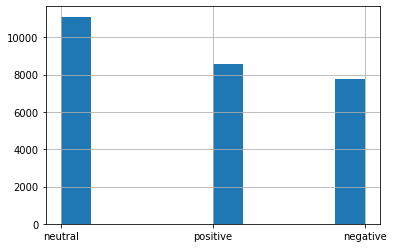

In [13]:
tweet_data['sentiment'].hist()

In [14]:
# mapping categorical data to number
def mapping_cat_to_num(col_name):
    tweet_data[col_name].unique()
    col_list = list(tweet_data[col_name].unique())
    col_dict = {}
    for i in range (len(col_list)):
        col_dict[col_list[i]] = i
    return col_dict


clean_nums={}
clean_nums =mapping_cat_to_num('sentiment')
clean_nums

{'neutral': 0, 'positive': 1, 'negative': 2}

In [15]:
tweet_data.replace(clean_nums,inplace=True)

In [16]:
tweet_data.head()

,text,sentiment
0,"oh Marly, I`m so sorry!! I hope you find her...",0
1,Playing Ghost Online is really interesting. Th...,1
2,is cleaning the house for her family who is co...,0
3,gotta restart my computer .. I thought Win7 wa...,0
4,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,0


In [17]:
tweet_data['sentiment'].astype('float').tail()

27443    2.0
27444    2.0
27445    1.0
27446    0.0
27447    1.0
Name: sentiment, dtype: float64

In [18]:
tweet_data['sentiment'].value_counts()

0    11105
1     8575
2     7767
Name: sentiment, dtype: int64

In [19]:
tweet_data['text'] = tweet_data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print(tweet_data['text'].head())

validation_data['text'] = validation_data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print(validation_data['text'].head())


0    oh marly, i`m so sorry!! i hope you find her s...
1    playing ghost online is really interesting. th...
2    is cleaning the house for her family who is co...
3    gotta restart my computer .. i thought win7 wa...
4    see wat i mean bout foll0w friidays... it`s ca...
Name: text, dtype: object
0     last session of the day http://twitpic.com/67ezh
1    shanghai is also really exciting (precisely --...
2    recession hit veronique branquinho, she has to...
3                                          happy bday!
4               http://twitpic.com/4w75p - i like it!!
Name: text, dtype: object


In [20]:
#stopwords
from nltk.corpus import stopwords
tweet_data['text'] = tweet_data['text'].apply(lambda x : ' '.join([word for word in x.split() 
                                                                   if not word in set(stopwords.words('english'))]))

validation_data['text'] = validation_data['text'].apply(lambda x : ' '.join([word for word in x.split() 
                                                                   if not word in set(stopwords.words('english'))]))

In [21]:
import re
import string

#Citation: Borrowed a few regex'es from Google
def process_tweets(text):
    text = str(text).lower() #lower
    text = re.sub('\[.*?\]', '', text) #Remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #Hyperlinks removal
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #punctuations
    text = re.sub('\n', '', text) #newlines
    text = re.sub('\w*\d\w*', '', text) #word containing numbers
    return text

In [22]:
#Pre-process the tweets
tweet_data['text'] = tweet_data['text'].apply(lambda x:process_tweets(x))
validation_data['text'] = validation_data['text'].apply(lambda x:process_tweets(x))

In [23]:
print(tweet_data['text'].head())
print("\n",validation_data['text'].head())


0                   oh marly im sorry hope find soon  
1    playing ghost online really interesting new up...
2            cleaning house family comming later today
3    gotta restart computer  thought  supposed put ...
4    see wat mean bout  friidays its called lose  f...
Name: text, dtype: object

 0                                    last session day 
1    shanghai also really exciting precisely  skysc...
2    recession hit veronique branquinho quit compan...
3                                           happy bday
4                                              like it
Name: text, dtype: object


In [24]:
#Stemming
stemmer = PorterStemmer()
tokenized_tweet = tweet_data['text'].apply(lambda x: x.split()) 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
print(tokenized_tweet.head())
tweets_training_set = []
for item in tokenized_tweet:
    tweets_training_set.append(' '.join(item))
print (len(tweets_training_set))

0             [oh, marli, im, sorri, hope, find, soon]
1    [play, ghost, onlin, realli, interest, new, up...
2             [clean, hous, famili, com, later, today]
3    [gotta, restart, comput, thought, suppos, put,...
4    [see, wat, mean, bout, friiday, it, call, lose...
Name: text, dtype: object
27447


In [25]:
tweet_data.head()

,text,sentiment
0,oh marly im sorry hope find soon,0
1,playing ghost online really interesting new up...,1
2,cleaning house family comming later today,0
3,gotta restart computer thought supposed put ...,0
4,see wat mean bout friidays its called lose f...,0


In [26]:
tweet_data['Analyzed_Tweet'] = tweets_training_set
tweet_data.head()

,text,sentiment,Analyzed_Tweet
0,oh marly im sorry hope find soon,0,oh marli im sorri hope find soon
1,playing ghost online really interesting new up...,1,play ghost onlin realli interest new updat kir...
2,cleaning house family comming later today,0,clean hous famili com later today
3,gotta restart computer thought supposed put ...,0,gotta restart comput thought suppos put end co...
4,see wat mean bout friidays its called lose f...,0,see wat mean bout friiday it call lose friday smh


In [27]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27447 entries, 0 to 27447
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            27447 non-null  object
 1   sentiment       27447 non-null  int64 
 2   Analyzed_Tweet  27447 non-null  object
dtypes: int64(1), object(2)
memory usage: 857.7+ KB


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer


## Naive Bayes

In [29]:
TfidfVectorizer()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [62]:
# TfTfidfVectorizer()
TFIDF_vector = TfidfVectorizer(max_features=2000) 
X = TFIDF_vector.fit_transform(tweet_data['text'].tolist()).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, tweet_data['sentiment'], test_size = 0.20, random_state = 2)

x_val = TFIDF_vector.fit_transform(validation_data['text'].tolist()).toarray()


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

naive_bayes = MultinomialNB().fit(X_train, y_train)

y_pred=naive_bayes.predict(X_test)

print("Accuracy\n",accuracy_score(y_test, y_pred))
print("\n\nConfusion Matrix\n",confusion_matrix(y_test, y_pred))
print("\n\nClassification Report\n",classification_report(y_test, y_pred))

Accuracy
 0.6400728597449908


Confusion Matrix
 [[1731  267  195]
 [ 637 1025   59]
 [ 749   69  758]]


Classification Report
               precision    recall  f1-score   support

           0       0.56      0.79      0.65      2193
           1       0.75      0.60      0.67      1721
           2       0.75      0.48      0.59      1576

    accuracy                           0.64      5490
   macro avg       0.69      0.62      0.63      5490
weighted avg       0.67      0.64      0.64      5490



In [63]:
import pickle  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(naive_bayes) 
  
# Load the pickled model 
rf_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
NB_y_pred=rf_from_pickle.predict(x_val) 
NB_y_pred

NB_validation = pd.DataFrame({'text':validation_data['text'],'sentiment':NB_y_pred})
NB_validation = NB_validation[['text','sentiment']]
NB_validation.to_csv("NB_validation.csv",index = False)
NB_df=pd.read_csv('NB_validation.csv')
NB_df.head()


,text,sentiment
0,last session day,2
1,shanghai also really exciting precisely skysc...,1
2,recession hit veronique branquinho quit compan...,0
3,happy bday,2
4,like it,1


In [64]:
CountVectorizer()

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [65]:
#changing the vector
count_vector = CountVectorizer(max_features=2000) 
X = count_vector.fit_transform(tweet_data['text'].tolist()).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, tweet_data['sentiment'], test_size = 0.20, random_state = 2)

x_val = TFIDF_vector.fit_transform(validation_data['text'].tolist()).toarray()


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

naive_bayes = MultinomialNB().fit(X_train, y_train)

y_pred=naive_bayes.predict(X_test)

print("Accuracy\n",accuracy_score(y_test, y_pred))
print("\n\nCOnfusion Matrix\n",confusion_matrix(y_test, y_pred))
print("\n\nClassification Report\n",classification_report(y_test, y_pred))

Accuracy
 0.6517304189435337


COnfusion Matrix
 [[1536  347  310]
 [ 504 1124   93]
 [ 578   80  918]]


Classification Report
               precision    recall  f1-score   support

           0       0.59      0.70      0.64      2193
           1       0.72      0.65      0.69      1721
           2       0.69      0.58      0.63      1576

    accuracy                           0.65      5490
   macro avg       0.67      0.65      0.65      5490
weighted avg       0.66      0.65      0.65      5490



In [66]:
import pickle  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(naive_bayes) 
  
# Load the pickled model 
rf_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
NB_y_pred=rf_from_pickle.predict(x_val) 
NB_y_pred

NB_validation = pd.DataFrame({'text':validation_data['text'],'sentiment':NB_y_pred})
NB_validation = NB_validation[['text','sentiment']]
NB_validation.to_csv("NB_validation_counter.csv",index = False)
NB_df=pd.read_csv('NB_validation_counter.csv')
NB_df.head()


,text,sentiment
0,last session day,2
1,shanghai also really exciting precisely skysc...,1
2,recession hit veronique branquinho quit compan...,0
3,happy bday,2
4,like it,1


## XGB classifier

In [67]:
!pip install xgboost

In [68]:
from xgboost import XGBClassifier

In [69]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [70]:
#changing the vector
count_vector = CountVectorizer(max_features=2000) 
X = count_vector.fit_transform(tweet_data['text'].tolist()).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, tweet_data['sentiment'], test_size = 0.20, random_state = 2)

x_val = TFIDF_vector.fit_transform(validation_data['text'].tolist()).toarray()


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

xgb = XGBClassifier().fit(X_train, y_train)

y_pred=xgb.predict(X_test)

print("Accuracy\n",accuracy_score(y_test, y_pred))
print("\n\nCOnfusion Matrix\n",confusion_matrix(y_test, y_pred))
print("\n\nClassification Report\n",classification_report(y_test, y_pred))

Accuracy
 0.6836065573770492


COnfusion Matrix
 [[1781  250  162]
 [ 495 1169   57]
 [ 684   89  803]]


Classification Report
               precision    recall  f1-score   support

           0       0.60      0.81      0.69      2193
           1       0.78      0.68      0.72      1721
           2       0.79      0.51      0.62      1576

    accuracy                           0.68      5490
   macro avg       0.72      0.67      0.68      5490
weighted avg       0.71      0.68      0.68      5490



In [71]:
import pickle  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(naive_bayes) 
  
# Load the pickled model 
rf_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
xgb=rf_from_pickle.predict(x_val) 
xgb_y_pred

xgb_validation = pd.DataFrame({'text':validation_data['text'],'sentiment':xgb_y_pred})
xgb_validation = xgb_validation[['text','sentiment']]
xgb_validation.to_csv("xgb_validation_counter.csv",index = False)
xgb_df=pd.read_csv('xgb_validation_counter.csv')
xgb_df.head()

NameError: name 'xgb_y_pred' is not defined